## Import Packages and Functions

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys, os, h5py
from pathlib import Path
import pandas as pd
from tqdm import tqdm
import spikeinterface.full as si
import spikeinterface.curation as sc

# Suppress warnings from spikeinterface
import warnings
warnings.filterwarnings("ignore")

# Add the path to the custom functions
sys.path.append("/home/ehefti/Github/DPQC")
import _functions.spike_sorting as ss
import _functions.screen_maxtwo_activity as sma
import _functions.quality_control as qc

## 1. Recording Overview

Found 24 wells in S:/group/hierlemann02/recordings/Maxtwo/phornauer/241218/EI_iNeurons/T002523/Network/000020/data.raw.h5
Analyzing 2 seconds from each well for a rough overview.


Processing Wells:   0%|          | 0/24 [00:00<?, ?it/s]

**********
Maxwell file format is based on HDF5.
The internal compression requires a custom plugin!!!
This is a big pain for the end user.
You, as a end user, should ask Maxwell company to change this.
Please visit this page and install the missing decompression libraries:
https://share.mxwbio.com/d/4742248b2e674a85be97/
Then, link the decompression library by setting the `HDF5_PLUGIN_PATH` to your
installation location, e.g. via
os.environ['HDF5_PLUGIN_PATH'] = '/path/to/custom/hdf5/plugin/'

Alternatively, you can use the auto_install_maxwell_hdf5_compression_plugin() below
function that do it automagically.

**********
  Error processing well well000: Can't synchronously read data (can't open directory). Skipping this well.
**********
Maxwell file format is based on HDF5.
The internal compression requires a custom plugin!!!
This is a big pain for the end user.
You, as a end user, should ask Maxwell company to change this.
Please visit this page and install the missing decompression 

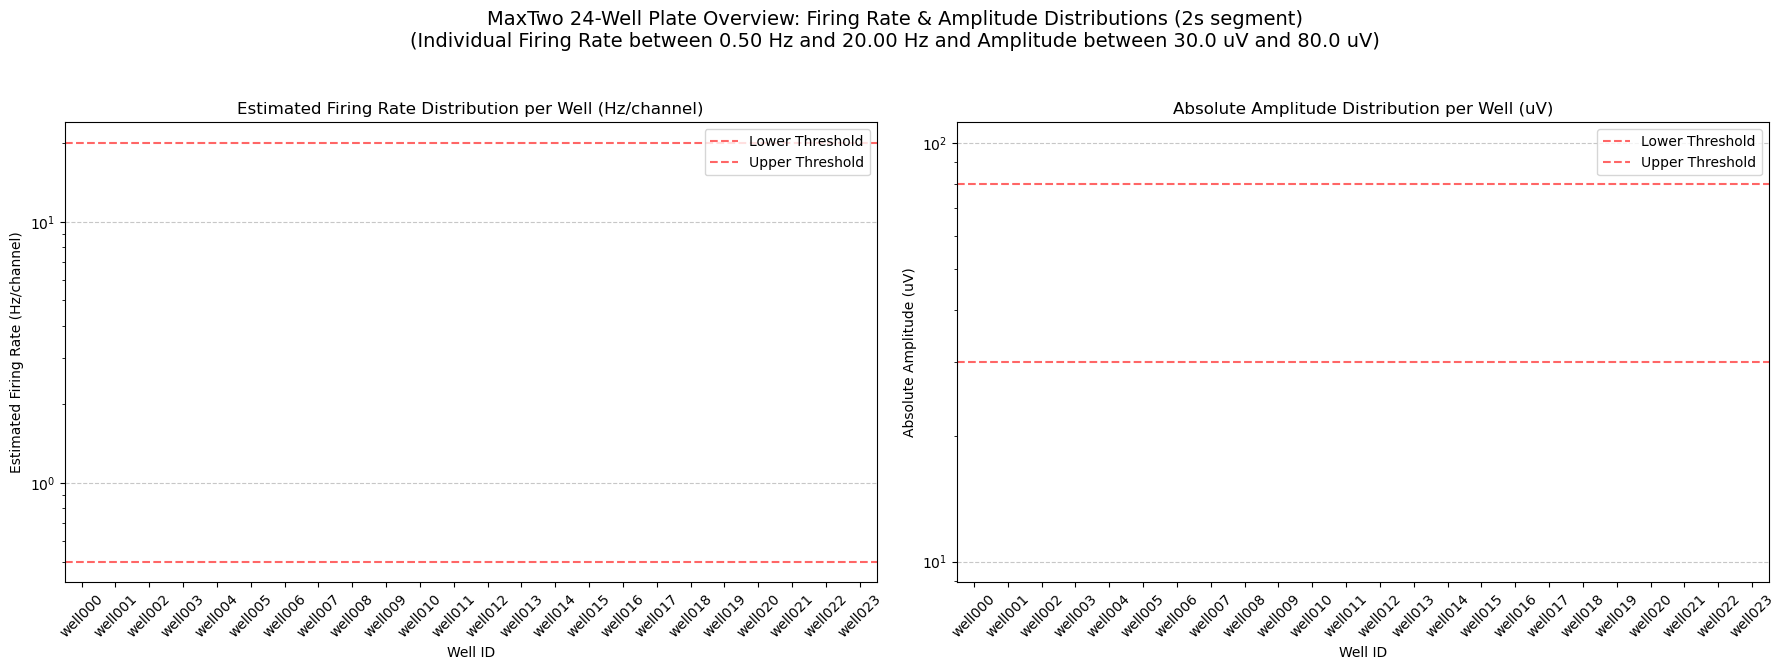

In [ ]:
# Set your paths
# Linux: '/net/bs-filesvr02/export/group/hierlemann/recordings/Maxtwo/.../data.raw.h5' 
# Windows: 'S:/group/hierlemann02/recordings/Maxtwo/.../data.raw.h5'

rec_path = '/net/bs-filesvr02/export/group/hierlemann/recordings/Maxtwo/phornauer/241218/EI_iNeurons/T002523/Network/000020/data.raw.h5'
save_root = '/net/bs-filesvr02/export/group/hierlemann/intermediate_data/Maxtwo/phornauer/EI_iNeurons/241218/T002523/Network/'

h5 = h5py.File(rec_path)
stream_ids = list(h5['wells'].keys())
stream_ids = stream_ids[0:24]


df_summary, rate_dist, amp_dist = sma.screen_maxtwo_activity(rec_path, segment_duration_s=2,
                                                             rate_lower_threshold = 0.5,
                                                             rate_upper_threshold = 20,
                                                             amp_lower_threshold = 30,
                                                             amp_upper_threshold = 80)


## 2. Spikesorting
_This part of the pipeline is computationally heavy. It is advisable to run this on a GPU or Cluster._

In [4]:
# Choose sorter and set parameters
sorter = 'kilosort2_5'
si.Kilosort2_5Sorter.set_kilosort2_5_path('/home/ehefti/Github/Kilosort')
sorter_params = si.get_default_sorter_params(si.Kilosort2_5Sorter)

sorter_params['n_jobs'] = -1
sorter_params['detect_threshold'] = 5.5 #6 als Standardwert
sorter_params['minFR'] = 0.01 #Lower value -> less units that get automatically deleted
sorter_params['minfr_goodchannels'] = 0.01
sorter_params['keep_good_only'] = False
sorter_params['do_correction'] = False
sorter_params['NT'] = 64*1024 + 64 #Batch size -> Wieviel wird auf einmal angeschaut

Setting KILOSORT2_5_PATH environment variable for subprocess calls to: c:\home\ehefti\Github\Kilosort


In [ ]:
for stream_id in tqdm(stream_ids):
    h5 = h5py.File(rec_path)
    rec_name = list(h5['wells'][stream_id].keys())[0]
    rec = si.MaxwellRecordingExtractor(rec_path, stream_id=stream_id, rec_name=rec_name)
    ss.clean_sorting(rec, save_root, stream_id=stream_id, sorter=sorter, sorter_params=sorter_params, clear_files=True)

## 3. Qualitycontrol (Machine Learning Model)

You can train your own Model if you want - this is not necessary though. There is a model that works reasonably well for MaxTwo EPhys data. If you train your own model it might be more precise for your cell-line, but it takes a while to label your units manually and train the model to get reasonable results. The pretrained Model will be loaded in the next step of the pipeline, you can jump to "Apply Model".

### Training your Model

```python
# If you want to testrun the code you can use this function and skip the next code block:
rec_train, sorting_train, analyzer = generate_ground_truth_data(
    durations=[10], 
    sampling_frequency=30000,
    num_channels=4
)
```

Creating an analyzer for your data

In [ ]:
# !! This controls how many cores you're using, only increase if the server is not used by others !!
si.set_global_job_kwargs(n_jobs = 6) # For no parallelisation use n_jobs = -1
os.environ['HDF5_PLUGIN_PATH'] = '/home/ehefti/Github/DPQC/MaxTwo_Quality_Control/'

#Choose the well you want to use for training the model
well_id = 'well001'

# Compute the analyzer
rec_train, sorting_train, analyzer = qc.compute_analyzer(rec_path, save_root, well_id, num_units_to_use=20, hp_cutoff_freq=1) # use num_units_to_use='all' to use all units

# Plot some unit templates
all_unit_ids = sorting_train.get_unit_ids()
si.plot_unit_templates(analyzer, unit_ids=all_unit_ids[:3], scale=5)

Applying high-pass filter with 1 Hz cut-off...
Restricted sorting to 20 units for development.


estimate_sparsity (workers: 6 processes):   0%|          | 0/1801 [00:00<?, ?it/s]

OSError: Can't synchronously read data (can't open directory)

Manually labeling the units in the GUI

In [ ]:
# Choose the directory where you want to save the labels
label_output_dir = Path(save_root) / well_id / 'sorter_output'

# Interactive GUI to manually label your data
updated_sorting = qc.interactive_unit_labeler(rec_train, sorting_train, analyzer, output_dir_for_labels=label_output_dir)

Training your model, given the manual labels

In [ ]:
# Choose the folder where your model should be saved
model_folder = "_models/"

# Load the labels from the chosed directory above
manual_labels = pd.read_csv(Path(label_output_dir) / 'manual_unit_labels.tsv', sep='\t')
manual_labels = manual_labels['quality_label'].tolist()

manual_labels = ['good' if unit_type == 'good' else 'bad' for unit_type in manual_labels]

# Train the model
trainer = sc.train_model(
    mode="analyzers",
    labels=[manual_labels],
    analyzers=[analyzer],
    folder=model_folder,
    overwrite=True, # Set to True if you want to overwrite existing models
    imputation_strategies = ["median"],
    scaling_techniques = ["standard_scaler"],
    classifiers = None, # Default: Random Forest. Other Classifiers: [ "AdaBoostClassifier","GradientBoostingClassifier","LogisticRegression","MLPClassifier"]
    search_kwargs = {'scoring': 'balanced_accuracy', 'cv': 3} # Parameters used during the model hyperparameter search
)

best_model = trainer.best_pipeline

accuracies = pd.read_csv(Path(model_folder) / "model_accuracies.csv", index_col = 0)
accuracies.head()

Evaluate your model's confidence and accuracy

In [ ]:
# Compute the model confidence and accuracy while plotting a confusion matrix
qc.plot_model_evaluation(analyzer=analyzer, model_folder=model_folder, manual_labels=manual_labels)

### Apply Model

In [ ]:
# Load a pretrained model if you did not train you own
if 'model_folder' not in locals():
    model_folder = '_models/'


# Run the model for all wells except the one you used for training
left_stream_ids = [stream_id for stream_id in stream_ids if stream_id != well_id]
for stream_id in tqdm(left_stream_ids):
    qc.auto_label_stream(rec_path, save_root, stream_id, model_folder)